<table style="width:100%"><tr>
<td> 
    
**Technische Universität Berlin**\
Electrical Engineering and Computer Science\
Internet of Things for Smart Buildings\
Prof. Dr. Sergio Lucia, Felix Fiedler, Benjamin Karg </td>
<td>  <img src="logo_tu.png" style="width: 20%;" align="right"/> </td>
</tr>
</table>

***
**Convex Optimization for the Internet of Things WS 19/20**
***


 
 <h1 style="font-size:50px;">Project 2 – Robust Optimization</h1> 
 Lucas Krauß, Viet Hoang Lai, Raschid Younes 
 <hr>

[Screencast-Link](https://tubcloud.tu-berlin.de/s/Q6nEHZ5fqePkQjj)

#### **Preliminaries: Installation of `ipywidgets`** 

In the following notebook we will use the `ipywidgets` library to create an interactive widget which you can use to explore our solution.  
You can install it with:

In [1]:
!pip install ipywidgets

If you use JupyterLab you additionally need to install the `jupyterlab-manager` extension.

In [ ]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Building jupyterlab assets (build:prod:minimize)
\

More detailed install instructions can be found [here](https://ipywidgets.readthedocs.io/en/latest/user_install.html).


#### **Importing Libraries, Loading Data**

In [1]:
print("Importing libraries ...\t", end="")
import cvxopt
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, display_markdown
import tqdm
import ipywidgets as w
import time
cvxopt.solvers.options['show_progress'] = False

print("Done.")

plt.style.use("ggplot")
print("Loading data ... \t", end="")
data = scipy.io.loadmat("./external_data.mat")
data = np.array(list(zip(data["T"], data["sr"], data["int"]))).squeeze().T
print("Done.")

Importing libraries ...	Done.
Loading data ... 	Done.


## **TOC**
### 1. [**Introduction**](#intro)
>#### 1.1 [Problem Statement](#problem)
>#### 1.2 [Motivation](#motivation)

### 2. [**Methodology**](#methods)
>#### 2.1 [Robust Optimization](#robust_optimization)
>>##### 2.1.2 [Robust Counterparts](#robust_counterpart)
>>##### 2.1.2.[TLDR](#tldr)
>#### 2.2 [Formulation of Robust LP](#robust_lp)
>#### 2.3 [Interior-Point Solver](#solver)

### 3. [**Results**](#results)
>#### 3.1 [Qualitative Evaluation](#quali)
>>#### 3.1.1 [Widget Structure](#widgetStruct)
>#### 3.2 [Quantitative Evaluation](#quant)
>#### 3.3 [Discussion](#discussion)

### 4. [**Summary**](#summary)
### 5. [**Appendix**](#appendix)

<hr>

## **1. Introduction** <a class="anchor" id="intro"></a>

### **1.1 Problem Statement** <a class="anchor" id="problem"></a>

In this project we are presented with an energy management optimization problem. 
We aim to apply robust optimization methods to optimize the given energy system.  
Here, we consider a system composed of the following building blocks:


- A solar panel which can *generate* energy.
- A battery which can *store* energy.
- A connection to the electricity grid which enables us to *sell* or *buy* energy.
- A building with a cooling or heating facility that can *consume* energy.

![environment](env.png)

In this problem we aim to **maximize the amount of energy being sold via the grid** while meeting certain **requirements** such as a suitable temperature within the building.

The following requirements are given (omitting bounds on variables):
- Room temperature withing [20.0 °C, 23.0 °C]
- Battery charge withing [0.0 %, 100 %]
- Power used for heating and cooling is non-negative
- Power is balanced, i.e., we use exactly as much power as we buy and/or produce


Possible control inputs that can influcence the system are:
- 🔥 Heating the building
    - Consuming energy 
    - Increasing the internal temperature
- ❄️ Cooling the building 
    - Consuming energy
    - Decreasing the internal temperature
- 💰 Selling to / buying from the grid 
    - Consuming or generating energy
- ⚡ Charging / discharging the battery 
    - Consuming or generating energy
    
Additionally, the following *external* factors (beyond our control) can affect the system:
- 🌡️ External temperature
    - Increasing or decreasing the internal temperature
- 🌞 Solar irradiation
    - Increasing the internal temperature
    - Producing energy via the solar panel
- ♨️ Internal gains
    - Increasing the internal temperature

The following plot shows an example subset of the three external factors:

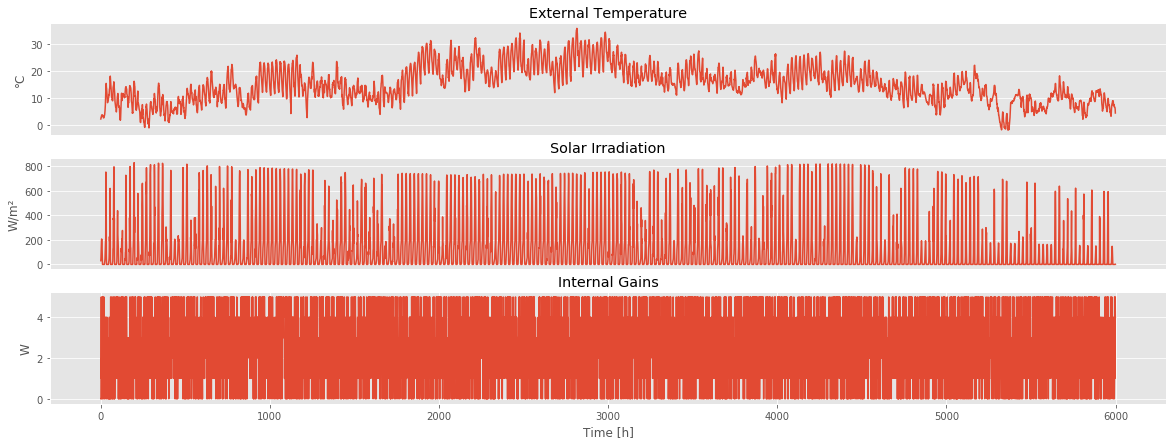

In [2]:
fig, ax = plt.subplots(nrows=3, figsize=(20,7))
for i, (titel, ylabel) in enumerate([("External Temperature", "°C"),("Solar Irradiation", "W/m²"), ("Internal Gains", "W")]):
    ax[i].plot(data[2000:8000,i])
    ax[i].set_title(titel)
    ax[i].set_ylabel(ylabel)
    if i < 2:
        ax[i].set_xticks([])
    else:
        ax[i].set_xlabel("Time [h]")

The problem of optimizing the energy system can be formulated as the following LP: 
$$\begin{align} &\mathop{\mathrm{minimize}}_{x,u} &\sum_{k=0}^{N-1} P_{grid}^k \\
&\mathrm{s.t.} &x_{lb} \leq x_k \leq x_{ub}&&\text{(Room temperature and battery charge constraints)} \\
& & u_{lb} \leq u_k \leq u_{ub}&&\text{(Bounds on control inputs)} \\
& & 0 = m_{lb} \leq Du_k + G d_k \leq m_{ub} = 0&&\text{(Balance constraints)} \\
& &  x_{k+1} = A x_k + B u_k + E d_k && \text{(State transitions)}
\end{align}$$

Since we want to solve this problem for multiple time steps ($N$) in advance, we need to know how the external factors will develop in near future
If we assume that we are able to predict these quantities exactly, we can solve the optimization problem using one initial state $x_0$ and the predictions for the external disturbances $d_k$.

The following few code cells will define the LP in standard form s.t. we can solve this problem based on the predictions.  
Additionally, we choose the initial state `x_0 = [21.5 °C , 50%]` to be within the constraints.

In [4]:
# Environment dynamics
A = np.array([[0.9511, 0.0], [0.0, 1.0]])
B = np.array([[0.0035, -0.0035, 0.0, 0.0], [0.0, 0.0, -5.0, 0.0]])
E = 1e-3 * np.array([[22.217, 2*1.7912, 42.212], [0.0, 0.0, 0.0]])

# Bounds on states
BAT_MAX_CAPACITY = 100*1e3 #kWh

x_lb = np.array([20.0, 0.0])
x_ub = np.array([23.0, BAT_MAX_CAPACITY])

# Bounds on inputs
u_lb = np.array([0.0, 0.0, -500.0, -500.0])
u_ub = np.array([1000.0, 1000.0, 500.0, 500.0])

# Mixed constraints
D = np.array([-1.0, -1.0, 1.0, 1.0])
G = np.array([0.0, 0.5, 0.0])



def plot_solution(sol,data, x_0):
    x = np.array(sol["x"])
    LIMITS = {0:[20,23],
              1:[0,BAT_MAX_CAPACITY],
              2:[0,1000],
              3:[0,1000],
              4:[-500,500],
              5:[-500,500]}
    
    simulated_states = simulate_dynamics(data, x_0)
    fig, ax = plt.subplots(nrows=4, figsize=(20, 12), sharex=True)
    
    for i, (caption, ylabel) in enumerate([("Internal Temperature", "°C"),("Battery Charge", "W")]):
        if i == 0:
            temp = [[x_0[i]]] + x[i::6].tolist()
            ax[i].scatter(np.arange(len(temp)), temp, c='#8EBA42')
            ax[i].plot(simulated_states[:,0], ls=":", c='#348ABD')
        else:
            ax[i].plot([[x_0[i]]] + x[i::6].tolist())
                          

        ax[i].axhline(LIMITS[i][0], ls="--", c="grey")
        ax[i].axhline(LIMITS[i][1], ls="--", c="grey")
        ax[i].set_title(caption)
        ax[i].tick_params(axis=u'x', which=u'both',length=0)
        ax[i].set_ylabel(ylabel)
        
    ax[-2].plot(data[:,0], c="orange")
    ax[-2].set_title("External Temperature")
    ax[-2].set_ylabel("°C")

    ax[-1].plot(0.5*data[:,1], c="orange")
    ax[-1].set_title("Power of PV")
    ax[-1].set_ylabel("W")
    ax[-1].set_xlabel("Time [h]")
    
def simulate_dynamics(data, x_0, uncertainty=0):
    x = [x_0]
    for i in range(len(data)):
        x.append(A@x[-1] + E@data[i])
    
    x = np.array(x)
    return x
    
    
def simulate_dynamics_with_controls(sol, data, x_0, uncertainty=0):
    controls = np.array(sol["x"]).reshape(-1)
    u_indices = [np.arange(2+i, 6+i) for i in range(0,len(controls),6)]
    
    uncertain_data = data*np.random.uniform(low=1 - uncertainty, high=1 + uncertainty, size=data.shape)
    assert len(u_indices) == uncertain_data.shape[0]
    
    x = [x_0]
    for i in range(len(u_indices)):
        x.append(A@x[-1] + B@controls[u_indices[i]] + E@uncertain_data[i])
    
    x = np.array(x)
    return x

def plot_solution_uncertain(sol, data, x_0, uncertainty=0.1):
    controls = np.array(sol["x"]).reshape(-1)
    x = simulate_dynamics_with_controls(sol, data, x_0, uncertainty)
    LIMITS = {0:[20,23],
              1:[0,BAT_MAX_CAPACITY],
              2:[0,1000],
              3:[0,1000],
              4:[-500,500],
              5:[-500,500]}

    fig, ax = plt.subplots(nrows=2, figsize=(20,6), sharex=True)   
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    
    temp = x[:,0]
    temp_in_constraints = (temp >= LIMITS[0][0]) & (temp <= LIMITS[0][1])
    green_temps = temp[temp_in_constraints]
    red_temps = temp[~temp_in_constraints]
    arr = np.arange(len(temp))[temp_in_constraints]
    ax[0].scatter(arr, green_temps, c=colors[5])
    arr = np.arange(len(temp))[~temp_in_constraints]
    ax[0].scatter(arr, red_temps, c=colors[0])    
    ax[0].set_title("Internal Temperature")
    ax[0].set_ylabel("°C")
    ax[0].axhline(LIMITS[0][0], ls="--", c="grey")
    ax[0].axhline(LIMITS[0][1], ls="--", c="grey")
    
    ax[1].plot(x[:,1])
    ax[1].set_title("Battery Charge")
    ax[1].set_ylabel("W")
    ax[1].axhline(LIMITS[1][0], ls="--", c="grey")
    ax[1].axhline(LIMITS[1][1], ls="--", c="grey")
    ax[1].set_xlabel("Time [h]")
    


        

def get_problem(N, data, x_0, uncertainty, verbose=False, return_bounds=False):    
    d = data[:N]
   
    # Dynamics
    A_ = np.empty(shape=(2*N, 2))
    E_ = np.zeros(shape=(2*N, 3*N))
    
    A_dynamics = np.zeros(shape=(2*N,6*N))

    # x_1N = AA x_0 + B u + E d <=> x_1N - B u = E d + AA x_0 <=> A_dynamics z  = E d + AA x_0 with z_i = [x_i,u_i].T
    for i in range(N):
        
        # ┌─────┐
        # │ A   │
        # │ A^2 │
        # │ ... │
        # │ A^N │
        # └─────┘
        A_[2*i:2*i+2] = np.linalg.matrix_power(A,i+1)
        
        # ┌─────────────────────┐
        # │ E      0    0       │
        # │ A*E    E    0       │
        # │ A^2*E  A*E  E       │
        # │ ...    ...  ...  .. │
        # └─────────────────────┘        
        E_[2*i:2*i+2, :3*(i+1) ] = np.hstack([np.linalg.matrix_power(A, j)@E for j in range(i,-1,-1)]) 
       
        A_dynamics[2*i:2*(i+1), 6*i:6*i+2] = np.eye(2)

        for j in range(i+1):
            A_dynamics[2*i:2*(i+1), 6*(j)+2: 6*(j+1)] = -np.linalg.matrix_power(A, i-j)@B   # -BB
            
        b_dynamics = A_@x_0 + E_@d.reshape(-1)
        
    if verbose:
        print("Dynamics\n",A_dynamics,"\n", b_dynamics)
                
    
    
    # Boundary constraints
    A_bounds = np.zeros(shape=(12*N,6*N))
    for i in range(0, 12*N, 12):
        j = int(i/12)
        A_bounds[i : i+2, j*6: j*6+2] = np.eye(2) 
        A_bounds[i+2 : i+4, j*6: j*6+2] = -np.eye(2) 
        A_bounds[i+4:i+8, j*6 + 2: j*6 + 6] = np.eye(4)
        A_bounds[i+8:i+12, j*6 + 2: j*6 + 6] = -np.eye(4)
     
    b_bounds = np.tile(np.hstack((x_ub, -x_lb, u_ub, -u_lb)),N)
    
    E_d = E_@(d.flatten())
    b_bounds[0::12] -=  (E_@((d*(uncertainty)).flatten()))[::2]
    b_bounds[1::12] -=  (E_@((d*(uncertainty)).flatten()))[1::2]
    b_bounds[2::12] +=  (E_@((d*(- uncertainty)).flatten()))[::2]
    b_bounds[3::12] +=  (E_@((d*(- uncertainty)).flatten()))[1::2]

    
    if verbose:
        print("bounds")
        print(A_bounds, "\n", b_bounds)
        print(A_bounds.shape, b_bounds.shape)

    # Balance constraints
    A_balance = np.zeros(shape=(2*N,6*N))
    for i in range(N):
        A_balance[2*i, int(6*i):6*(i+1)] = np.hstack([np.zeros(2), D])
        A_balance[2*i+1, int(6*i):6*(i+1)] = np.hstack([np.zeros(2), -D])
    
    b_balance = np.array((-(1 - uncertainty)*d@G, (1+uncertainty)*d@G)).reshape(-1,order="F")

    if verbose:
        print("Balance")
        print(A_balance,"\n", b_balance)
        print(A_balance.shape, b_balance.shape)

    
    # Bring everything together in standard form.
    c = []
    for i in range(N):
        c.extend([0,0,0,0,0,1])

    if verbose:
        print(f"C:\n\t{c}")
    lp_c = cvxopt.matrix(c, (len(c),1), "d")
    
    lp_A = cvxopt.matrix(np.vstack((A_dynamics, -A_dynamics, A_bounds, A_balance))) # Dont forget -A_dynamics for the equalites
    lp_b = cvxopt.matrix(np.hstack((b_dynamics, -b_dynamics, b_bounds, b_balance)))
    if return_bounds:
        return lp_c, lp_A, lp_b, b_bounds
    return lp_c, lp_A, lp_b

In [6]:
x_0 = [21.5, BAT_MAX_CAPACITY/2]

Now we solve the LP for a time horizon of 24 h.  
In the below plot we show the obtained solution with the corresponding bounds in red. The blue dotted line depicts how the environment would have changed if we did not perform any control inputs.

In [7]:
lp_c, lp_A, lp_b = get_problem(N=24, data=data[5004:], x_0 = x_0, uncertainty=0)

In [8]:
sol_nonrobust = cvxopt.solvers.lp(c=lp_c, G=lp_A, h=lp_b )

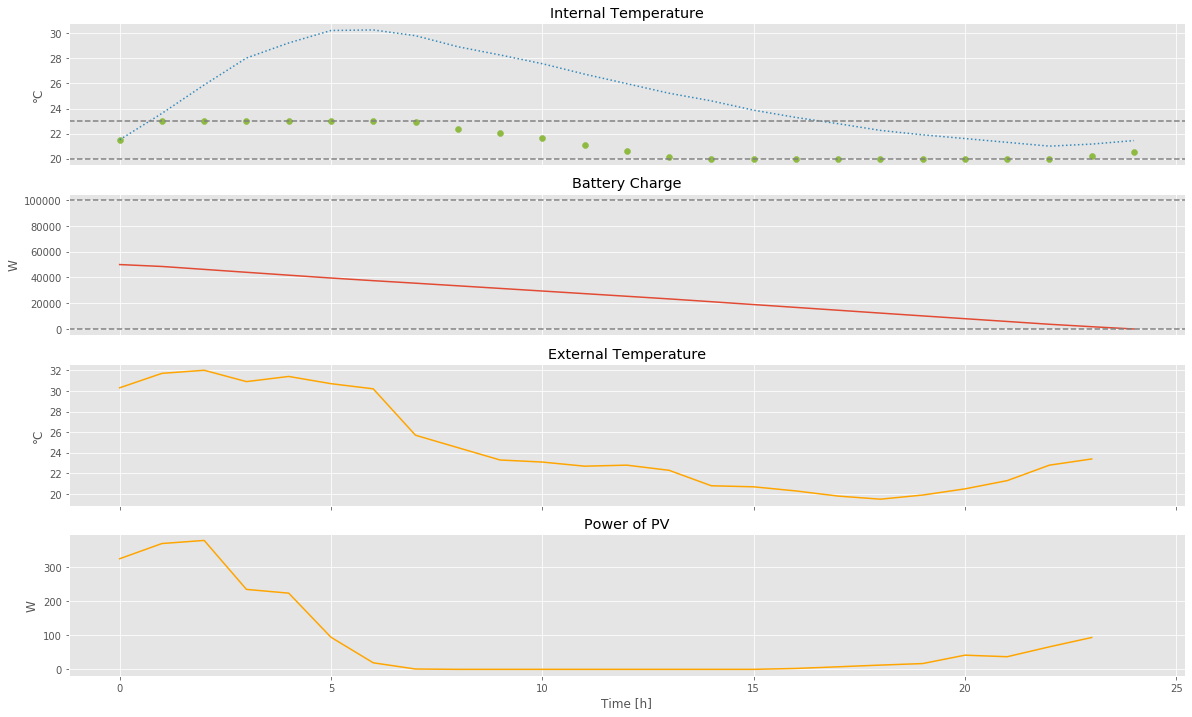

In [9]:
plot_solution(sol_nonrobust, data[5004:5028], x_0)

### **1.2 Motivation** <a class="anchor" id="motivation"></a>

In the above plot we can see that the solution to the LP operates the energy system s.t. the internal temperature is at its limits for long periods. This is optimal w.r.t. the provided data and the optimization objective but can be problematic when we no longer assume that the predictions for the external disturbances are known exactly.  
It is rarely appropriate to assume that we do know factors such as external temperature or solar irradiation exact for longer periods in advance. Instead, one can only assume that the predicted values are close to the true values within some margin of error.

Below, we simulate the same solution as above with some added uncertainty of 10% to the external factors, i.e., we assume that our predictions can deviate up to 10% from the true values.  
We can observe that in this case the system is no longer operated within the imposed constraints since the internal temperature exceeds its allocated bounds.

In [ ]:
plot_solution_uncertain(sol_nonrobust, data[5004:5028], uncertainty=0.1, x_0 = x_0)

A reason for this violation is that the inital solution achieves its optimal value when operating the system at its bounds.
Therefore, it is not robust to small pertubations in the input data.

To cope with such scenarios we employ methods of robust optimization that are explained in the following.

## **2. Methodology** <a class="anchor" id="methods"></a>

### **2.1 Robust Optimization** <a class="anchor" id="robust_optimization"></a>

In many real-world optimization problems it is quite natural to assume that the data is uncertain, i.e., it is not known exactly at the time  the problem is being solved.
These data uncertainties can arise from measurement and estimation errors among others.  
The effects of such uncertainties can be severe, ranging from worse objective values under the real data to solutions that become infeasible when being applied to the true data (because constraints are violated – see example above).

*Robust optimization* is one approach to deal with such uncertainties.  
The aim of robust optimization is to take uncertainties already into account when solving the optimization problem in the first place, i.e., before the uncertain data reveals itself.  
The goal is to find the "best uncertainity-immunized" solution [**[1]**](#book).  
In other words, in robust optimization we are interested in solutions to our problem that are feasible under all uncertainties.

Since we rarely know the form of the uncertainties, we have to make some assumptions about how the uncertainties can affect the data. For example we could assume that our measurements deviate from the true data up to 10%.

In the following we will give a more formal introduction to robust optimization:  
For that, consider a linear optimization problem in standard form:
$$\min_x \{ c^Tx - d : Ax \leq b\}$$ 
If we now assume, that some parts of our data (e.g. a subset of $(c,d,A,b)$) are affected by uncertainty we can formulate an *uncertain linear optimization* problem:
$$\left\{ \min_x \{ c^Tx - d : Ax \leq b\} \right\}_{(c,d,A,b) \in \mathcal U}$$
where $\mathcal U$ is the *uncertainty set*.   

The uncertainty set $\mathcal U$ contains all data within the assumed uncertainty bounds.  
For example, if we assume a multiplicative uncertainty of 10%, the subset of the uncertainty set $\mathcal U_b$ corresponding to $b$ could defined as:
$$\mathcal U_b = \left\{w\cdot b_0 : w \sim U(0.9, 1.10)\right\}$$
i.e., the true value of $b$ can deviate up to 10% around the assummed or measured data $b_0$.  
(here $w \sim U(0.9, 1.10)$ indicates that $w$ is drawn from a uniform distribution over the interval $[0.9, 1.1]$ )


Since a uncertain linear optimization problem is a familiy of linear optimization problems and therefore not associated with the concepts of feasibilty and optimal values, we first have to define this terms:    
We call $x$ a *robust feasible* solution to an uncertain LP if it satisfies all constraints for all realizations of the uncertainty set, i.e.,
$$Ax \leq b \quad \forall (c,d,A,b) \in \mathcal U$$
Based on this we can define the *robust value* of a robust feasible solution as the largest value of the "true" objective $c^Tx + d$ over all realizations of the data in $\mathcal U$.
$$\hat c(x) = \sup_{(c,d,A,b) \in \mathcal U} [c^Tx + d]$$
Informally, this is the value the solution attains in the case of the 'worst' realizations of data.


#### **2.1.1 Robust Counterparts** <a class="anchor" id="robust_counterpart"></a>

Using this definitions we can define a new optimization problem, the so called robust counterpart of the uncertain problem.
              $$\min_x \left\{ c(x) = \sup_{(c,d,A,b) \in \mathcal U} [c^Tx +d] : Ax \leq b \quad \forall(c,d,A,b) \in \mathcal U \right\}$$
Note that all solutions to the robust counterpart are immunized to the uncertainty, i.e., they are feasible as long as the uncertainties are within the assumed bounds / within the uncertainty set.
The optimal solution to the robust counterpart is called a robust optimal solution to the uncertain problem.  

In the robust counterpart our objective becomes to minimize the largest value of our inital objective at $x$ over all realizations from the uncertainty set $\mathcal U$.
(Since we want to minimize and choose the largest value this is equal to the worst case scenario w.r.t. $\mathcal U$.)
In other words, we now try to find the best worst-case solution w.r.t. the uncertainties.

Note that in general the robust counterpart of an optimization problem does not have to be the same class of optimization problems as the original problem. But in some cases the robust counterpart of a LP is it self again a LP.

#### **2.1.2 TLDR** (Too Long, Didn't Read) <a class="anchor" id="tldr"></a>


- World is noisy 
    - Measurements are not exact.
    - Noisy measurements can have negative effects
- Robust Optimization tries to solve this
    - Take uncertainties into account to:
        - Find solutions that are feasible under uncertain data
    - Uncertainties are not known -> Need to make assumptions
    - Formalism:
        - Optimization problem and uncertain set (encoding assumptions about noise) -> uncertain problem
        - Solution of uncertain problem is immunized to the assumed noise
        - Formally:
            - Solution has to remain feasible whatever the realization of the data in the uncertain set
        - Robust counterpart and interpretation (running example: Linear Optimization)
            - Uncertain problem not associated with the concepts of feasibility / optimal values (family of problems)
            - Define robust feasible solution as solution that satisfies all realizations of the constraints under the uncertainty set
              $Ax \leq b \quad \forall (c,d,A,b) \in \mathcal U$
            - The robust value of a robust feasible solution is the largest value of the "true" objective $c^Tx + d$ over all realizations of data in $\mathcal U$ (per definition this solution is feasible for all realizations).
              $$\hat c(x) = \sup_{(c,d,A,b) \in \mathcal U} [c^Tx + d]$$
              Informally, this is the value the solution attains in the case of the 'worst' realizations of data.
            - Using this definitions we can define a new optimization problem, the so called robust counterpart of the uncertain problem.
              $$\min_x \left\{ c(x) = \sup_{(c,d,A,b) \in \mathcal U} [c^Tx +d] : Ax \leq b \quad \forall(c,d,A,b) \in \mathcal U \right\}$$
              In the robust counterpart we aim to minimize the robust value (the worst-case value) over all robust feasible solutions.
              The optimal solution to the robust counterpart is called a robust optimal solution to the uncertain problem.

### **2.2 Formulation of Robust LP** <a class="anchor" id="robust_lp"></a>
Here we now derive the robust counterpart for our problem of optimizing our energy system.  
Recall, our problem was defined in the following way:
$$\begin{align} &\mathop{\mathrm{minimize}}_{x,u} &\sum_{k=0}^{N-1} P_{grid}^k \\
&\mathrm{s.t.} &x_{lb} \leq x_k \leq x_{ub}&&\text{(Room temp and battery charge constraints)} \\
& & u_{lb} \leq u_k \leq u_{ub}&&\text{(Bounds on control inputs)} \\
& & 0 = m_{lb} \leq Du_k + G d_k \leq m_{ub} = 0&&\text{(Balance constraints, untertain)} \\
& &  x_{k+1} = A x_k + B u_k + E d_k && \text{(State transitions, uncertain)}
\end{align}$$

Here, we assume that the external disturbances $d_k$ are uncertain with a multiplicative noise of 10%.
More precisely, we have:
$$d_k^{real} = w\cdot d_k^{pred} \quad \text{with } w \sim U(0.9, 1.1)$$
It follows that our uncertain set $\mathcal U$ can be defined in the following way:
$$\mathcal U = \left\{w \cdot d_k^{pred} : w \sim U(0.9, 1.1)\right\}$$

Formally, our robust counterpart becomes the following:
$$\min_{x,u} \begin{Bmatrix} c(x) = \sup_{d \in \mathcal U} [\sum_{k=0}^{N-1} P_{grid}^k] : & x_{lb} \leq x_k \leq x_{ub} \\ &u_{lb} \leq u_k \leq u_{ub} \\ &m_{lb} \leq Du_k + G d_k \leq m_{ub}&\quad \forall d_k \in \mathcal U \\ &x_{k+1} = A x_k + B u_k + E d_k &\quad \forall d_k \in \mathcal U \end{Bmatrix}$$

Since we are dealing with a LP the uncertain data $d$ influences the solution only linearly.
Therefore, we can consider only the boundaries of the uncertainty set in the robust couterpart.
More precisesly, instead of requiring $m_{lb} \leq Du_k + G d_k \leq m_{ub}\forall d_k \in \mathcal U$ and $x_{k+1} = A x_k + B u_k + E d_k \forall d_k \in \mathcal U$ we can reformulate into:

$$\begin{align} m_{lb} \leq Du_k + G d_k \leq m_{ub} &\quad \forall d_k \in \{0.9 \cdot d_k^{pred}, 1.1 \cdot d_k^{pred}\} \\ x_{k+1} = A x_k + B u_k + E d_k &\quad \forall d_k \in \{0.9 \cdot d_k^{pred}, 1.1 \cdot d_k^{pred}\} \end{align}$$

Using this insight, we can reformulate the robust counterpart in the following problem:
$$\begin{align} &\mathop{\mathrm{minimize}}_{x,u} &\sum_{k=0}^{N-1} P_{grid}^k \\
&\mathrm{s.t.} &x_{lb} \leq x_k \leq x_{ub} \\
& & u_{lb} \leq u_k \leq u_{ub} \\
& &  Du_k + G d_k \cdot 1.1 \leq m_{ub}\\
& &  Du_k + G d_k \cdot 0.9 \geq m_{lb}\\
& & x_{k+1} \leq A x_k + B u_k + E d_k \cdot 1.1 \\
& & x_{k+1} \geq A x_k + B u_k + E d_k \cdot 0.9 
\end{align}$$

Note that **the reformulated robust counterpart is again a LP**. In this case the only "cost" we have to pay for robustness are some additional constraints which account for the uncertainty.

## **3. Results** <a class="anchor" id="results"></a>

### **3.1 Qualitative Evaluation using a widget** <a class="anchor" id="quali"></a>

Now we compare the robust solution to the non-robust solution w.r.t. how easily they are influenced by uncertainty.  
In the following widget, you can select from multiple values of uncertainty $n$ and different time horizons $T$. In the generated plot you can compare the results obtained from the non-robust problem (left column) to the solution of the robust solution (right column). Both solutions are shown under influence of the selected uncertainty $n$.  
Note that it might be required to decrease either the amount of noise or the selected time horizon to obtain a feasible solution.

#### **3.1.1 Widget Structure**  <a class="anchor" id="widgetStruct"></a>

The presented widget consists of some instruments, to adapt the setting of the problem and a solver, that tries to solve a normal optimal solution and a robust optimal solution. 
- Upper row
    - left: slider is for adapting the multiplicative uncertainty for the predicted external disturbances within [0%, 30%] 
    - center Box is for adapting the horizon of the LP. The value of this box is linked with the second indicator of the big range-slider below
    - right Box is for setting the initial state $x_0$ (internal temp. and energy of the battery) of the linear state equation. It is important th set a feasible state here [20 -23] and [0% 100%]


- Center Row
    - Range Slider for choosing a range for the external disturbances. For a better intuition, there is a plot below to show the external temperature with a range of the beginning of January to the end of July. With changing the range, the upper box for the horizon will automatically be updated.


- Bottom Row
    - "Run Interact" Button for starting the solver and plotting the results.


- Output
    - After pressing the "Run Interact" button, there will be printed some information, about the setting of the problem and then the solver starts to find an optimal solution. After that, the solver will try to find a robust optimal solution. If the solver has not found both solutions, it prints the information that the setting should be adapted.


- Plots
    - Left
        - The optimal solution of the control inputs $u_0^*, \dots, u_{N-1}^*$ will be used to calculate the new states $x_1, \dots, x_{N}$ while using the predicted data with the given uncertainty. If the uncertainty is higher than 0%, the chance is high that there states will not be within the constraints anymore. This is illustrated with the green and red dots.
    - Right
        - The robust optimal solution of the control inputs $u_0^*, \dots, u_{N-1}^*$ will also be used to calculate the new states and typically it is seen, that the states are more far to the constraints. If the robust solver could not find a robust optimal solution, it will plot the bounds of the internal temperature. Typically it it shows some intersections between the lower and upper bound wich makes it impossible to find a solution.
    - Bottom
        - Furhtermore the external temperature and the power gained from the PV ( Photovoltaic) are shown for a better understanding of the solution.

In [10]:
def matrix_extend(A,N):
        
        # ┌─────┐
        # │ A   │
        # │ A^2 │
        # │ ... │
        # │ A^N │
        # └─────┘
    A_ = A
    for i in range(2,N+1):
        A_ = np.vstack((A_, A **i))
    return A_


def matrix_reformulation(A,E,N):
        # ┌─────────────────────┐
        # │ E      0    0       │
        # │ A*E    E    0       │
        # │ A^2*E  A*E  E       │
        # │ ...    ...  ...  .. │
        # └─────────────────────┘   
    nA = A.shape[1]
    nE = E.shape[1]
    E_ = np.zeros(shape=(nA*N, nE*N))
    for i in range(N):
        E_[2*i:2*i+2, :nE*(i+1) ] = np.hstack([np.linalg.matrix_power(A, j)@E for j in range(i,-1,-1)])
    return E_

def getCasadiOptimum(offset,N,x0,uncertainty=0.0):
    na = np.newaxis
    
    U_0N_1 = SX.sym("u",4,N)
    u_0N_1 = U_0N_1.reshape( (4*N,1))
     
    # calc A_, B_, E_ for reformulating the state space equation
    A_ = matrix_extend(A,N)
    B_ = matrix_reformulation(A,B,N)
    EN =  matrix_reformulation(A,E,N)
    #print(EN)
    
    nE = E.shape[1]
    d = data.T
    D_1N = d[:,offset:N+offset]
    d_1N = d[:,offset:N+offset].reshape(N*nE,order='F')
    

    d_uncertain =d * np.random.uniform(1-uncertainty, 1 + uncertainty, (3,np.shape(d)[1]))
    D_1N_uncertain = d_uncertain[:,offset:N+offset]
    
    m_lb = 0
    m_ub = 0

    m1_lb = 0
    m1_ub = 0
    m2_lb = 0
    m2_ub = 0

    
    #print(' A_   @  x0 + B_   @  u_0N_1 + EN   @  d_1N')
    #print(A_.shape, x0.shape, B_.shape, u_0N_1.shape, EN.shape, d_1N.shape)
       
    # FIXME uncertainty constraints
    xj_1N = (A_ @ x0 + B_ @ u_0N_1 + EN @ d_1N)
    #xj_1N_uncertain_lower = (A_ @ x0 + B_ @ u_0N_1 + EN @ ((1-uncertainty)*d_1N_uncertain_Tshifted))
    #xj_1N_uncertain_upper = (A_ @ x0 + B_ @ u_0N_1 + EN @ ((1+uncertainty)*d_1N_uncertain_Tshifted))
    x_1N_fun = Function('x_1N',[u_0N_1],[xj_1N])
    
    def x_1N(x0, u_1N):
        x = x_1N_fun(u_1N).full().reshape(2,N, order='F')
        x = np.hstack( (x0[:,np.newaxis], x) )
        return x
    
    # Objective J
    c = np.array([0, 0, 0, 1])[:,na]
    c = matrix_extend(c,N)
    J = c.T @ u_0N_1
    #print(J)
    
    # define constraints needed for solver
    x_ub_1N = np.tile(x_ub, N)
    x_lb_1N = np.tile(x_lb,N)
    
    u_ub_1N = np.tile(u_ub,N)
    u_lb_1N = np.tile(u_lb,N)
    
    m_ub_1N = np.tile(m_ub,N)
    m_lb_1N = np.tile(m_lb,N)
    
    m1_ub_1N = np.tile(m1_ub,N)
    m1_lb_1N = np.tile(m1_lb,N)
    m2_ub_1N = np.tile(m2_ub,N)
    m2_lb_1N = np.tile(m2_lb,N)
    
    #DN = matrix_extend(D,N)
    #DN = DN.T
    #print(DN)
    
    GN = matrix_extend(G,N)
    #print(GN)
    
    P_PV = G @ D_1N
    
    m_1N = (D[na,:] @ U_0N_1).T + (G @ D_1N)[:,na]
    m_1N_fun = Function('m_1N',[u_0N_1],[m_1N])
    
    # g represents inequality constraints
    g = vertcat(u_0N_1, m_1N, xj_1N) 
    ub = vertcat(u_ub_1N, m_ub_1N, x_ub_1N)
    lb = vertcat(u_lb_1N, m_lb_1N, x_lb_1N)
    
    # initial guess u0
    # solver setup
    #u0 = np.zeros( (N*4,1) )
    u0 = np.random.uniform(0,500,(N*4,1))
    
    # Try different Solvers
    # nlpsolver     -> Nonlineaer Problem
    # qpsol         -> 'qpoases' online active set strategy for qudratic Problems, also nonconvex
    # conic         -> 'clp' simplex or interier based method for linear Programs
    #prob0 = {'x':u_0N_1,'f':0,'g':g}
    #solver0 = nlpsol('solver0','ipopt',prob0)
    #solver0 = qpsol('solver0','qpoases',prob0)
    #u0 = solver0(x0=u0, ubg=ub, lbg=lb)['x']
    
    #            ┌───────────────────────────┐
    # for conic: │ min (1/2 x.T H x + g.T x) │
    #            │  x                        │
    #            └───────────────────────────┘
    #
    D_ = np.zeros( (N,4*N))
    for i in range(4*N):
        if (4*i+4 < 4*N):
            D_[i,4*i:4*i+4] = D[na,:]
    D_[-1,-4:] =  D[na,:]
    
    # NLP declaration: x decision vars, f objective,  g constraints
    prob = {'x':u_0N_1,'f':J,'g':g}
    opts = {'verbose_init': False, 'print_time': False, 'verbose':False}
    
    #solver = conic('solver','clp',prob)
    
    #solver = nlpsol('solver','ipopt',prob, opts)
    solver = qpsol('solver','qpoases',prob)
    start = time.time()
    
    with casadi.tools.capture_stdout() as out:
        res = solver(x0=u0, ubg=ub, lbg=lb)['x']
    timespend = ((time.time() - start)*1e3)
    print('\nExecution Time: {:.3f} ms'.format(timespend))
    u_opt = res.full().reshape( (4,N), order='F' )
    x1_N = x_1N(x0,res[:])
    sol = { 'u_opt' : u_opt,'x':x1_N }
    return sol

def x_systemDynamics(x0, u_k, D_1N):
    N = u_k.shape[1]
    x_k = np.zeros( (2,N+1) )
    x_k[:,0] = x0
    for i in range(N):
        x_k[:,i+1] = A @ x_k[:,i] + B @ u_k[:,i] + E @ D_1N[:,i]
    return x_k

#x_0 = np.array([22, 50 *1e3])
#sol_nonRobust = getCasadiOptimum(3,3,x_0)
#sol_nonRobust['x']


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03\xb6\x00\x00\x02\x02\x08\x02\x00\x00\x00t\xb4\xc6…

Box(children=(SelectionSlider(continuous_update=False, description='Uncertainty', index=1, layout=Layout(grid_…

IntRangeSlider(value=(5004, 5028), continuous_update=False, description='Set Range:', layout=Layout(height='80…

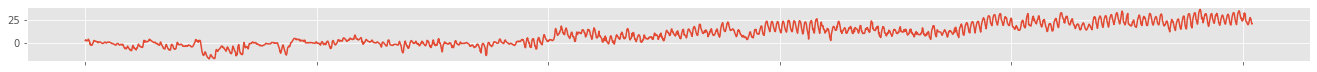

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

In [11]:
# Graphical Application for Presentation 

# widgets
# open Image
file = open("env2.png", "rb")
image = file.read()
wImage = w.Image(
    value=image,
    format='png',
    width=700,
    height=400,
)

wSlider1_uncertainty = w.SelectionSlider(
    options=['0%', '10%', '15%', '20%', '25%', '30%'],
    value='10%',
    description='Uncertainty',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

wSlider2 = w.IntRangeSlider(
    value=[5004, 5028],
    min=0,
    max=int(24*30*7),
    step=1,
    description='Set Range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout=w.Layout(width='99%', height='80px'),
    #slider_color = 'red'   
)

wText1 = w.IntText(
    value=24,
    placeholder='Type Horizon N here',
    description='Horizon:',
    disabled=False,
    continuous_update = True
)

wText2 = w.Text(
    value='22,   50%',
    placeholder='Type Temp and Battery Cap in %',
    description='$x_0$ :',
    disabled=False
)

wDropDown = w.Dropdown(
    options=['CVXOPT', 'CasADi', 'Own_Interior_Method'],
    value='CVXOPT',
    description='Solver:',
    disabled=False,
)

wLabelLeft = w.Label(value='Nonrobust solver with uncertainty data:',font_size=75)
wLabelRight = w.Label(value='Robust solver without uncertainty data:',font_size=75)
wOutput = w.Output()

# Layouts

item_layout = w.Layout(height='100px', min_width='40px')
#items = [wSlider1_uncertainty, wText1, wText2, wDropDown]
items = [wSlider1_uncertainty, wText1, wText2]
box_layout = w.Layout(overflow='scroll hidden',
                    border='',
                    width='100%',
                    height='',
                    flex_flow='row',
                    display='flex')
controlHeader = w.Box(children=items, layout=box_layout)

wLayoutUpper = w.AppLayout(header=None,
          left_sidebar=wSlider1_uncertainty,
          center=wText1,
          right_sidebar=wText2,
          footer=None)

wLayoutTitles = w.AppLayout(header=None,
          left_sidebar=wLabelLeft,
          center=None,
          right_sidebar=wLabelRight,
          footer=None)


# Plots

def plot_widget_new(sol_nonRobust, sol_robust, data, x_0, uncertainty, bounds, solver_option = 'CVXOPT', has_solution=True):
    LIMITS = {0:[20,23],
          1:[0,BAT_MAX_CAPACITY]}
    simulated_states = simulate_dynamics(data, x_0, uncertainty)
    x_nonRobust = simulate_dynamics_with_controls(sol_nonRobust, data, x_0, uncertainty)
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    if (not has_solution):
        fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(24,7), sharex=True)
        arr = np.arange(len(bounds[::12]))
        ax[0,1].scatter(arr,bounds[::12], ls="--", label="Upper bound", c="blue")    
        ax[0,1].scatter(arr,-bounds[2::12], ls=":", label="Lower bound", c="black")     
        ax[0,1].set_title('Bounds for internal temperature')
        ax[0,1].set_ylabel("°C")
        ax[0,1].axhline(LIMITS[0][0], ls="--", c="grey")
        ax[0,1].axhline(LIMITS[0][1], ls="--", c="grey")
        ax[0,1].legend()
        
        
        # non Robust
        temp = x_nonRobust[:,0]
        temp_in_constraints = (temp >= LIMITS[0][0]) & (temp <= LIMITS[0][1])
        green_temps = temp[temp_in_constraints]
        red_temps = temp[~temp_in_constraints]
        arr = np.arange(len(temp))[temp_in_constraints]
        
        ax[0,0].scatter(arr, green_temps, c=colors[5])
        arr = np.arange(len(temp))[~temp_in_constraints]
        ax[0,0].plot(simulated_states[:,0], ls=":",c=colors[1])
        ax[0,0].scatter(arr, red_temps, c=colors[0])    
        ax[0,0].set_title("Internal Temperature")
        ax[0,0].axhline(LIMITS[0][0], ls="--", c="grey")
        ax[0,0].axhline(LIMITS[0][1], ls="--", c="grey")
        ax[0,0].set_ylabel("°C")

        ax[1,0].plot(x_nonRobust[:,1])
        ax[1,0].set_title("Battery Charge")
        ax[1,0].axhline(LIMITS[1][0], ls="--", c="grey")
        ax[1,0].axhline(LIMITS[1][1], ls="--", c="grey")
        ax[1,0].set_xlabel("Time [h]")
        ax[1,0].set_ylabel("W")

    else :
        controls = np.array(sol_nonRobust["x"]).reshape(-1)
        N = data.shape[0]
        #print('N: {}'.format(N))
        #controls = np.array(sol_nonRobust).reshape(-1)
        if (solver_option == 'CVXOPT'):
            x_nonRobust = simulate_dynamics_with_controls(sol_nonRobust, data, x_0, uncertainty)
        elif (solver_option == 'CasADi') :
            D_1N = data.T
            u_k0 = np.zeros( (4,N) )
            x_nonRobust = x_systemDynamics(x_0, u_k0, D_1N)
        x_robust = simulate_dynamics_with_controls(sol_robust, data, x_0, uncertainty)
        simulated_states = simulate_dynamics(data, x_0, uncertainty)


        fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(24,7), sharex=True)   
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        #simulated_states = simulate_dynamics(data, x_0)

        temp = x_nonRobust[:,0]
        temp_in_constraints = (temp >= LIMITS[0][0]) & (temp <= LIMITS[0][1])
        green_temps = temp[temp_in_constraints]
        red_temps = temp[~temp_in_constraints]
        arr = np.arange(len(temp))[temp_in_constraints]

        # non Robust
        ax[0,0].scatter(arr, green_temps, c=colors[5])
        arr = np.arange(len(temp))[~temp_in_constraints]
        ax[0,0].plot(simulated_states[:,0], ls=":",c=colors[1])
        ax[0,0].scatter(arr, red_temps, c=colors[0])    
        ax[0,0].set_title("Internal Temperature")
        ax[0,0].axhline(LIMITS[0][0], ls="--", c="grey")
        ax[0,0].axhline(LIMITS[0][1], ls="--", c="grey")
        ax[0,0].set_ylabel("°C")

        ax[1,0].plot(x_nonRobust[:,1])
        ax[1,0].set_title("Battery Charge")
        ax[1,0].axhline(LIMITS[1][0], ls="--", c="grey")
        ax[1,0].axhline(LIMITS[1][1], ls="--", c="grey")
        ax[1,0].set_xlabel("Time [h]")
        ax[1,0].set_ylabel("W")

        # Robust
        arr = np.arange(len(x_robust))
        ax[0,1].scatter(arr,x_robust[:,0], c=colors[5])    
        ax[0,1].plot(simulated_states[:,0], ls=":",c=colors[1]) 
        ax[0,1].set_title("Internal Temperature")
        ax[0,1].axhline(LIMITS[0][0], ls="--", c="grey")
        ax[0,1].axhline(LIMITS[0][1], ls="--", c="grey")
        ax[0,1].set_ylabel("°C")

        ax[1,1].plot(x_robust[:,1])
        ax[1,1].set_title("Battery Charge")
        ax[1,1].axhline(LIMITS[1][0], ls="--", c="grey")
        ax[1,1].axhline(LIMITS[1][1], ls="--", c="grey")
        ax[1,1].set_xlabel("Time [h]")
        ax[1,1].set_ylabel("W")
   
    plt.suptitle('Non-Robust Solution                                                                          Robust Solution', fontsize=20)
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(24,3.5), sharex=True)
    #fig1.tight_layout()
    ax[0].plot(data[:,0], c="orange")
    ax[0].set_title("External Temperature")
    ax[0].set_xlabel("Time [h]")
    ax[0].set_ylabel("°C")
    ax[1].plot(0.5*data[:,1], c="orange")
    ax[1].set_title("Power of PV")
    ax[1].set_xlabel("Time [h]")
    ax[1].set_ylabel("W")
    plt.suptitle('External Disturbances', fontsize=20) 
    #fig.subplots_adjust(top=1.1)

    
    
# On Run Interactive
    
def runOptimization():
    # get Input data
    offset = wSlider2.value[0]
    N = wSlider2.value[1] - wSlider2.value[0]
    uncertainty_str = wSlider1_uncertainty.value
    uncertainty = int(uncertainty_str.split("%")[0])/100
    x_0 = wText2.value.split(',')
    x_0[0] = float(x_0[0].strip())
    x_0[1] = float(x_0[1].strip().split("%")[0])/100 * BAT_MAX_CAPACITY
    x_0 = np.asarray(x_0)
    # choose solver
    solver_option = wDropDown.value
    
    verbose = True
    if verbose:    
        print('x_0: {}'.format(x_0))
        print('offset: {}'.format(offset))
        print('N: {}'.format(N))
        print('uncertainty: {}'.format(uncertainty))
        print('solver_option: {}'.format(solver_option))
    
    
    # CVXOPT Version
    if (solver_option == 'CVXOPT'):
        # run solver not Robus
        lp_c, lp_A, lp_b, bounds = get_problem(N=N, data=data[offset:], x_0 = x_0, uncertainty=0.0, return_bounds=True)
        print('start solver ...')
        start1 = time.time()
        #solvers.options['show_progress'] = False
        sol_nonRobust = cvxopt.solvers.lp(c=lp_c, G=lp_A, h=lp_b)
        timespend1 = ((time.time() - start1)*1e3)
        #print('\nExecution Time: {:.3f} ms'.format(timespend))
        
        # run solver Robust
        lp_c, lp_A, lp_b, bounds  = get_problem(N=N, data=data[offset:], x_0 = x_0, uncertainty=uncertainty, return_bounds=True)
        #print('start solver ...')
        start2 = time.time()
        sol_robust = cvxopt.solvers.lp(c=lp_c, G=lp_A, h=lp_b)
        timespend2 = ((time.time() - start2)*1e3)
        has_solution = sol_robust['x'] != None
        if (not has_solution):
            print('No solution found! Reduce uncertainty or lower the horizon!')
        else :
            print('found solutions')
            print('----------------------')
            print('\nExecution Time: {:.3f} ms'.format(timespend1 + timespend2))
        print('')
        plot_widget_new(sol_nonRobust, sol_robust, data[offset:offset+N], x_0, uncertainty, bounds, solver_option = solver_option, has_solution=has_solution)
        
    # Casadi Version
    elif (solver_option == 'CasADi'):
        start1 = time.time()
        lp_c, lp_A, lp_b = get_problem(N=N, data=data[offset:], x_0 = x_0, uncertainty=0.0)
        
        # test other formulation
        if False:
            x = SX.sym("x",6,N)
            H = DM.zeros(6*N,6*N)
            A_conic = DM.ones(np.array(lp_A).shape) * np.array(lp_A)
            g = np.array(lp_c)
            #lba = -1000 * np.ones((336,1))
            uba = np.array(lp_b)
            qp = {}
            qp['h'] = H.sparsity()
            qp['a'] = A_conic.sparsity()
            
            # not working, says not an LP
            solver_conic = conic('solver_conic','clp',qp)
            print(solver_conic)
            sol_conic = solver_conic(h=H, g=g, a=A_conic, uba=uba)['x']
            print(sol_conic)
            return
        
        sol_nonRobustCasadi = cvxopt.solvers.lp(c=lp_c, G=lp_A, h=lp_b, solver='glpk', options={'glpk':{'msg_lev':'GLP_MSG_OFF'}})
        print('sol_nonRobustCasadi.shape: {}'.format(np.shape(sol_nonRobustCasadi['x'])))
        sol_nonRobust = getCasadiOptimum(offset,N,x_0)
        print('sol_nonRobust {}'.format(np.shape(sol_nonRobust['x'])))
        timespend1 = ((time.time() - start1)*1e3)
        
        # run solver Robust
        lp_c, lp_A, lp_b, bounds = get_problem(N=N, data=data[offset:], x_0 = x_0, uncertainty=uncertainty, return_bounds=True)
        #print('start solver ...')
        start2 = time.time()
        sol_robust = cvxopt.solvers.lp(c=lp_c, G=lp_A, h=lp_b, solver='glpk', options={'glpk':{'msg_lev':'GLP_MSG_OFF'}})
        timespend2 = ((time.time() - start2)*1e3)
        has_solution = sol_robust['x'] != None
        if (not has_solution):
            print('No solution found, reduce uncertainty or lower the horizon')
        else :
            print('found solutions')
            print('----------------------')
            print('\nExecution Time: {:.3f} ms'.format(timespend1 + timespend2))
        print('')
        plot_widget_new(sol_nonRobust, sol_robust, data[offset:offset+N], x_0, uncertainty, bounds, solver_option = solver_option, has_solution=has_solution)

    # own solver Version
    elif (solver_option == 'Own_Interior_Method'):
        print(' 404 not found')
        # TODO

        
# Display everything
display(wImage)
display(controlHeader)
display(wSlider2)

# External Temperature Plot
with wOutput:
    fig = plt.figure(figsize=(23,1))
    plt.plot(data[:24*30*7,0])
    frame1 = plt.gca()
    frame1.axes.xaxis.set_ticklabels([])
    plt.style.use('ggplot')
#frame1.axes.yaxis.set_ticklabels([])


SliderOutput = w.interact_manual(runOptimization,i=wSlider2);

# Events / Synchronisation

def int_range_slider_to_int_text_int_text(change, t2=wText1):
    #t1.value= change['new'][0]
    t2.value= change['new'][1] - change['new'][0]

def int_text_to_int_range_slider(change, t1=wSlider2):
    old = t1.value
    new = (old[0], old[0] + change['new'])
    t1.value = new

wText1.observe(int_text_to_int_range_slider, names='value')    
wSlider2.observe(int_range_slider_to_int_text_int_text, names='value')



### **3.2 Quantitative Evaluation** <a class="anchor" id="quant"></a>

In addition to the above qualitative evaluation, we now simulate the obtained solutions for the non-robust problem and the robust problem for `N = 10000` realizations of uncertain data with an uncertainty of 10%.

In [ ]:
lp_c, lp_A, lp_b = get_problem(N=24, data=data[5004:5028], x_0 = x_0, uncertainty=0.1)

In [ ]:
sol_robust = cvxopt.solvers.lp(c=lp_c, G=lp_A, h=lp_b )

In [ ]:
N_TRIALS = 10000
n_failed_nonrobust = 0
n_failed_robust = 0

for _ in tqdm.trange(N_TRIALS):
    x = simulate_dynamics_with_controls(sol_nonrobust, data[5004:5028], x_0, uncertainty=0.1)
    temp = x[:,0]
    bat = x[:,1]
    
    constraints_violated = ((temp > 23) | (temp < 20) | (bat > BAT_MAX_CAPACITY) | (bat < 0)).any()
    n_failed_nonrobust += constraints_violated

    x = simulate_dynamics_with_controls(sol_robust, data[5004:5028], x_0, uncertainty=0.1)
    temp = x[:,0]
    bat = x[:,1]
    
    constraints_violated = ((temp > 23) | (temp < 20) | (bat > BAT_MAX_CAPACITY) | (bat < 0)).any()
    n_failed_robust += constraints_violated

quant_df = pd.DataFrame(columns=["Non-Robust Solution", "Robust Solution"])
quant_df.loc["# Failed"] = [n_failed_nonrobust, n_failed_robust]
quant_df.loc["% Suceeded"] = [(1 - n_failed_nonrobust/N_TRIALS)*100, (1 - n_failed_robust/N_TRIALS)*100.0]

display_markdown("#### Simulation Results", raw=True)
display(quant_df)

We can observe the following:
- A large majority of simulations using the non-robust solution violated the constraints. The solution to the non-robust problem is able to solve not even 1% of trials.  
- The robust solution on the other hand did not violate the constraints even once. 
  This shows by example that the solution to the robust problem is immune against pertubations as long as their magnitude does not exceeds the assumed uncertainty.

### **3.3 Discussion** <a class="anchor" id="discussion"></a>

In this report we have seen that robust optimization is a suitable technique to deal with uncertain data. Solutions found with robust optimization are immunized to pertubations assumed prior to optimization.  

Nevertheless, robust optimization has a few drawbacks:
1. Often, the robust counterpart is a far more complex problem than the inital problem. E.g. even for simple problems the robust counterpart can be a semi-infinite program, i.e., a problem with a finite number of variables but an *infinite* number of constraints.
2. Even in the case that we can reformulate our robust problem to a problem with finite constraints, the number of constraints is larger than in the original problem. This increase in complexity is the price we have to pay to be robust against uncertainties.
3. Furthermore, the robust problem is often only feasible for shorter time horizons. The reason for this is that the uncertainty accumulates over time and therefore the constrains get more and more narrow. This behavior can be observed in the plots below:

In [ ]:
lp_c, lp_A, lp_b, bounds = get_problem(N=24, data=data[5004:], x_0 = x_0, uncertainty=0.1, return_bounds=True)

In [ ]:
sol = cvxopt.solvers.lp(c=lp_c, G=lp_A, h=lp_b)

In [ ]:
temp = np.array(sol["x"])[::6]

plt.figure(figsize=(20,4))

plt.scatter(np.arange(len(temp)),temp, label="Solution", c=plt.rcParams["axes.prop_cycle"].by_key()["color"]
    [5])
plt.plot(bounds[::12], ls="--", label="Uncertainty ajusted constraints", c="grey")
plt.plot(-bounds[2::12], ls="--", c="grey")
plt.ylabel("°C")
plt.title("Internal Temperature")
plt.legend()
display_markdown("### Influence of Uncertainty on Temperature-Constraints\n**Uncertainty = 10%**", raw=True)

For higher uncertainties, we can often not solve the problem very far: This is even true for an increase of **0.5** percent additional uncertainty

In [ ]:
lp_c, lp_A, lp_b, bounds = get_problem(N=24, data=data[5004:], x_0 = x_0, uncertainty=0.105, return_bounds=True)

In [ ]:

plt.figure(figsize=(20,4))

plt.plot(bounds[::12], ls="--", label="Upper bound", c="grey")
plt.plot(-bounds[2::12], ls=":", label="Lower bound", c="grey")
plt.ylabel("°C")
plt.title("Internal Temperature")
plt.legend()
display_markdown("**Uncertainty = 10.5%**", raw=True)

## **4. Summary** <a class="anchor" id="summary"></a>
- Robust Optimization
    - For an optimization problem and its uncertainty set $\mathcal U$ we want to find a solution that is feasible for **all** data $\in \mathcal U$.  
    - We can reformulate a uncertain optimization problem into a new optimization problem, the so-called **robust counterpart**.
    - All solutions to the robust counterpart are immunized to the uncertainty, i.e., they are feasible as long as the uncertainties are within the assumed bounds.
    - The optimial solution to the robust counterpart is the best worst-case solution (where the worst-case is w.r.t. the uncertainties).
    - The robustness comes at the price of an increased complexitiy of the problem, i.e., a larger number of constraints (possibly infinite).

## **5. Appendix** <a class="anchor" id="appendix"></a>


### **5.1 References**
- **[1]**<a class="anchor" id="book"></a> – A. Ben-Tal, L. El Ghaoui, and A. Nemirovski, Robust optimization, vol. 28.  Princeton University Press, 2009 
- [Standford Lecture Notes Spring '18](https://web.stanford.edu/class/ee364b/lectures/robust_notes.pdf)
- [Paper: Theory and applications of Robust Optimization](http://www.mit.edu/~dbertsim/papers/Robust%20Optimization/Theory%20and%20applications%20of%20robust%20optimization.pdf)
- [Robust Solutions of Uncertain Linear Programs, Ben-Tal, Nemirovski](https://www2.isye.gatech.edu/~nemirovs/stablpn.pdf) (Very similar to the book chapter)

### **5.2 Own Implementation of Interior Point Method**

For solving Linear Problems with inequality constraints, there are several ways of implement an optimization solver. One way is the Active Point Method, but in this LP we have hard constraints therefore we can't neglect any constraints. The Interior Point Method is predestinated to stay always in a feasible set. It is an effective way, still with many constraints.

In the following, you can find an interior point based prototype of a LP solver. The Interior Point solver is using the newton method and logarithmic barrier functions for the constraints

In [ ]:

# Import everything (*) from casadi
from casadi import *
# We also already import matplotlib for plotting:
import matplotlib.pyplot as plt
# And numpy because we cant live without numpy (it gives as matrices <3:
import numpy as np
import scipy.io
# Primal Interior Point Method

xinit = np.array(sol["x"])

c_ = np.array(lp_c)
A_ = np.array(lp_A)
b_ = np.array(lp_b)


# get A, x, b and c i.e. def PIPM(A, x, b, c)
A_barr = A_
b_barr = b_
c_barr = c_
x_barr = casadi.SX.sym("x", 6*1,1)         

# define the barrier function
barr = casadi.sum1(-log(-(A_@x_barr - b_.flatten())))
# define objective function
J = c_.T@x_barr

gamma_vals = [0.1, 1.0, 3.0, 7.0, 20.0, 40.0, 100.0]
gamma = SX.sym("gamma")
barrier_expr = J + 1/gamma * ( barr )
barrier_fun = Function("barrier_fun",[x_barr,gamma],[barrier_expr])

alpha = 0.3 # step length 
# change to adaptive?
gamma_tol = 1e-6
    
x_init = []
for i in range(len(c_)//6):
    x_init.extend([ 21.5, BAT_MAX_CAPACITY/2, 0,0,0,0, ])


    # Compute jacobian and hessian
dJ = jacobian( barrier_expr, x_barr )
ddJ = hessian(barrier_expr,x_barr)[0]
newton_direction = Function("newton_direction",[x_barr,gamma],[alpha * inv(ddJ) * dJ.T])

for gv in gamma_vals:
    d = newton_direction(x_init, gv)
    if casadi.norm_inf(d) < gamma_tol:
        break
    x_init = x_init - d.T
        
    print('The optimal value for gamma = {} is x = {}'.format(gv, x_init))

    

**WIP**: Might not work, since the inequality constraints reformulated from the equality constraints might cause undefined behaviour for the logarithmic barrier functions. One way is Constraint Elimination with reformulating the LP with second order approximation into a QP with equality constraints. The solution can then be found analytically